In [1]:
import pandas as pd
import json
import requests
import time
from matplotlib import pyplot as plt

In [22]:
player_gamertags = []

user_input = input('Input player gamertags to compare one at a time. When done, input # : ')

while user_input != '*':
    player_gamertags.append(user_input)
    user_input = input('Input player gamertags to compare one at a time. When done, input # : ')
    if user_input == '#':
        break
    

# player_gamertags = ['ElamAce', 'Sparty TG', 'Wumbology']

player_data = {}
# rank, winrate, games played, favorite gametype, favorite weapon

player_data_gbv = {}
# winrate, objective data?, k/d, assists?, number of games

# player_data_gbv_df = pd.DataFrame()

player_data_match = {}
# winrate, k/d,  


gbv = ['Strongholds',
 'Slayer',
 'Breakout',
 'Capture the Flag',
 'Warzone Assault',
 'Warzone',
 'Campaign',
 'Big Team CTF',
 'Big Team Strongholds',
 'Big Team Slayer',
  None,
 'Assault',
 'Grifball',
 'Warzone Firefight',
 'Infection',
 'Campaign Score Attack',
 'Mini-game',
 'Oddball',
 'Big Team Assault']

class Api:
    """  
    This class will call the Halo 5 API and create a dataframe with data for each of
    the provided gamertags
    """
    __api_key = '7022fb201e5a4b35bdf2104472004f9c'
    
    game_base_variants = {}
    
    maps = {}
    
    headers = {
    'Ocp-Apim-Subscription-Key' : __api_key
}
    
    params = {
    'players' : player_gamertags,
}
     
    arena_service_record = 'https://www.haloapi.com/stats/h5/servicerecords/arena'
    
    gbv_url = 'https://www.haloapi.com/metadata/h5/metadata/game-base-variants'
    
    maps_url = 'https://www.haloapi.com/metadata/h5/metadata/maps'
    
    def __init__(self):
        self.resultcount25 = True
        self.match_columns = ['Map', 'Game Mode', 'Total Kills', 'Total Deaths', 'Total Assists']
        self.matchurl = None
        self.paramsmatch = {
        'players' : player_gamertags,
        'count' : 25,
        'start' : 0
    }
    
    def retrieve_gbv_data(self):
        try:
            # call the halo 5 api and store the information for ArenaGameBaseVariantStats in a dataframe
            req = requests.get(self.arena_service_record, params=self.params, headers=self.headers)
            data = req.json()
            for gamertags in range(len(player_gamertags)):
                player_data_gbv[player_gamertags[gamertags]] = pd.DataFrame(data['Results'][gamertags]['Result']['ArenaStats']['ArenaGameBaseVariantStats'])
        except:
            print(req.status_code)
            print('Error retrieving data')
            
    def retrieve_match_data(self):
        # this method isn't being entirely used yet. I want to be able to visualize data from a player's match history
        # in order to track improvements over time and things like that. I didn't have enough time before the end of the project to finish,
        # but it still stores a player's match history into a dataframe!
        
        for x in range(len(player_gamertags)):
            # for each of the gamertags, set the start parameter to 0 initially.
            self.paramsmatch['start'] = 0
            player_data_match[player_gamertags[x]] = pd.DataFrame(columns=self.match_columns)
            self.resultcount25 = True
            while self.resultcount25 == True:
                # the API can only retrieve data for 25 games at a time. This loop calls the API, stores the data for
                # 25 for each of the gamertags, then goes on to the next 25 games in the player's
                # match history. The repeats until it has retrieved data for all games.
                self.matchurl = f'https://www.haloapi.com/stats/h5/players/{player_gamertags[x]}/matches'
                matchreq = requests.get(self.matchurl, params = self.paramsmatch, headers = self.headers)
                matchdata = matchreq.json()
                try:
                    if matchdata['ResultCount'] < matchdata['Count']:
                        self.resultcount25 = False
                        break
#                     elif self.paramsmatch['start'] > 5000:
#                         self.resultcount25 = False
#                         break
                    for index in range(len(matchdata['Results'])):
                        player_data_match[player_gamertags[x]] = player_data_match[player_gamertags[x]].append({'Map' : matchdata['Results'][index]['MapId'], 'Game Mode' : matchdata['Results'][index]['GameBaseVariantId'], 'Total Kills' : matchdata['Results'][index]['Players'][0]['TotalKills'], 'Total Deaths' : matchdata['Results'][index]['Players'][0]['TotalDeaths'], 'Total Assists' : matchdata['Results'][index]['Players'][0]['TotalAssists']}, ignore_index=True)
                        self.paramsmatch['start'] += 1
                except:
                    print(matchdata)
                time.sleep(len(player_gamertags))
                # a sleep function had to be added as this loop can easily hit the request limit of 200 req/10 seconds.            
             
    def retrieve_metadata(self, url):
        # retrieves metadata for gametypes
        self.url = url
        req = requests.get(self.url, headers = self.headers)
        data = req.json()
        self.game_base_variants = pd.DataFrame(data)
        
    def retrieve_metadata_maps(self, url):
        # retrieves metadata for maps
        self.url = url
        req2 = requests.get(self.url, headers = self.headers)
        data2 = req.json()
        self.maps = pd.DataFrame(data2)
        
class DataClean:
    """
    This class will replace the the Id values with metadata values retrieved from the metadata API.
    It will also remove unneeded columns and and construct a dataframe of desired data.
    """
    
    metadata_id = {}
    
    def __init__(self):
        call_api = None
        metadata_replace = None
        metadata_id = None
        metadata_replace_map = None
        metadata_id_map = None
    
    def gbv_data_clean(self):
        
        self.call_api = Api()
        self.call_api.retrieve_metadata(self.call_api.gbv_url)
        self.metadata_replace = pd.DataFrame(self.call_api.game_base_variants)
        self.metadata_id = pd.Series(self.metadata_replace.name.values,index=self.metadata_replace.id).to_dict()
        
        for i in range(len(player_gamertags)):
            for x in range(len(player_data_gbv[player_gamertags[i]]['GameBaseVariantId'])):
                # this takes the metadata taken from the API and replaces the metadata id with the actual game mode name
                player_data_gbv[player_gamertags[i]]['GameBaseVariantId'][x] = self.metadata_id[player_data_gbv[player_gamertags[i]]['GameBaseVariantId'][x]]
        
        for i in range(len(player_gamertags)):
            # renames the column from GameBaseVariantId to Game Mode
            player_data_gbv[player_gamertags[i]].rename(columns = {
                'GameBaseVariantId' : 'Game Mode'
            }, inplace=True)
        
        for x in range(len(player_gamertags)):
            # adds a column for win percentage based on total games/games won*100
            # adds a column for kill/death ratio based on total kills/total deaths
            
            player_data_gbv[player_gamertags[x]]['Win Percentage'] = (player_data_gbv[player_gamertags[x]]['TotalGamesWon'] / player_data_gbv[player_gamertags[x]]['TotalGamesCompleted'])*100
            player_data_gbv[player_gamertags[x]]['K/D Ratio'] = player_data_gbv[player_gamertags[x]]['TotalKills'] / player_data_gbv[player_gamertags[x]]['TotalDeaths']
            player_data_gbv[player_gamertags[x]]['PowerWeaponGrabs/Game'] = player_data_gbv[player_gamertags[x]]['TotalPowerWeaponGrabs'] / player_data_gbv[player_gamertags[x]]['TotalGamesCompleted']
            player_data_gbv[player_gamertags[x]]['Kills/Game'] = player_data_gbv[player_gamertags[x]]['TotalKills'] / player_data_gbv[player_gamertags[x]]['TotalGamesCompleted']
            player_data_gbv[player_gamertags[x]]['Assists/Game'] = player_data_gbv[player_gamertags[x]]['TotalAssists'] / player_data_gbv[player_gamertags[x]]['TotalGamesCompleted']
            
        for x in range(len(player_gamertags)):
            player_data_gbv[player_gamertags[x]] = player_data_gbv[player_gamertags[x]][['Game Mode', 'Win Percentage', 'TotalGamesCompleted', 'K/D Ratio', 'TotalKills', 'Kills/Game', 'TotalDeaths', 'TotalAssists', 'Assists/Game', 'PowerWeaponGrabs/Game', 'TotalGamesWon', 'TotalGamesLost']]
            player_data_gbv[player_gamertags[x]].set_index('Game Mode', inplace=True)
            
            
class CompareStats:
    """
    This class will use the other two classes to pull and clean player stats data
    in order to compare them
    """
    def __init__(self):
        
        self.call_api = Api()
        self.call_api.retrieve_gbv_data()
        self.replace_metadata = DataClean()
        self.replace_metadata.gbv_data_clean()
        
        self.gbv_dataframe = None
        self.gbv_columns = ['Win Percentage', 'TotalGamesCompleted', 'K/D Ratio', 'TotalKills', 'Kills/Game', 'TotalDeaths', 'TotalAssists', 'PowerWeaponGrabs/Game', 'TotalGamesWon', 'TotalGamesLost']
        
        self.match_dataframe = None
    
    def gbv_data(self):
        
        self.gbv_dataframe = pd.DataFrame()
        self.gbv_dataframe['Game Mode'] = gbv
        # making a dataframe where the index will be all of the possible gametypes
    
        for i in range(len(self.gbv_columns)):
            for x in range(len(player_gamertags)):
                # make a column named stats: gamertag for each of the gamertags that are being compared
                self.gbv_dataframe[f'{self.gbv_columns[i]}: {player_gamertags[x]}'] = None
        
          
        for i in range(len(self.gbv_dataframe)):
            for x in range(len(player_gamertags)):
                # if the gamertags provided have data for the gametype, then created a column for that player for each of the
                # stats we are including
                if self.gbv_dataframe['Game Mode'][i] in player_data_gbv[player_gamertags[x]].index:
                    for c in range(len(self.gbv_columns)):
                        self.gbv_dataframe[f'{self.gbv_columns[c]}: {player_gamertags[x]}'][i] = player_data_gbv[player_gamertags[x]][f'{self.gbv_columns[c]}'][self.gbv_dataframe['Game Mode'][i]]
        
        self.gbv_dataframe.set_index('Game Mode', inplace=True)
        self.gbv_dataframe.dropna(how='all', inplace=True)
        # drop all rows (gametypes) that were not played at all by any of the given gamertags
        
    def gametype_graph_bar(self, stat, gametype):
        # makes a bar graph to compare players.
        # the x axis will be the player gamertags, and it will show 'stat' on the y axis
        # for the specified gametype.
        self.stat = stat
        self.gametype = gametype
        self.gbv_dataframe.fillna(value=0, inplace=True)

        for x in range(len(player_gamertags)):   
            plt.bar(player_gamertags[x], self.gbv_dataframe[f'{self.stat}: {player_gamertags[x]}'][f'{self.gametype}'])
            plt.ylabel(f'{self.stat}')
            plt.title(f'Game Mode: {self.gametype}')
        plt.show()

        
            

Input player gamertags to compare one at a time. When done, input # : Sparty TG
Input player gamertags to compare one at a time. When done, input # : ElamACE
Input player gamertags to compare one at a time. When done, input # : Str8 SicK CS
Input player gamertags to compare one at a time. When done, input # : #


In [23]:
halo5 = CompareStats()
halo5.gbv_data()
player_data_gbv[player_gamertags[0]]
# this is a dataframe of gametype stats pulled for one player

C:\Users\hunte\anaconda3\lib\site-packages\ipykernel_launcher.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Win Percentage,TotalGamesCompleted,K/D Ratio,TotalKills,Kills/Game,TotalDeaths,TotalAssists,Assists/Game,PowerWeaponGrabs/Game,TotalGamesWon,TotalGamesLost
Game Mode,,,,,,,,,,,
Strongholds,77.115275,3522,1.644159,55469,15.749290,33737,24461,6.945202,0.395798,2716,805
Breakout,77.835951,573,2.275418,5304,9.256545,2331,1755,3.062827,0.247818,446,127
Slayer,75.610891,4297,1.818464,70771,16.469863,38918,27170,6.323016,0.834536,3249,1045
Big Team Slayer,50.000000,2,2.428571,17,8.500000,7,8,4.000000,0.000000,1,1
Big Team CTF,50.000000,2,2.857143,20,10.000000,7,4,2.000000,0.000000,1,1
Oddball,68.200837,239,1.362429,5026,21.029289,3689,2492,10.426778,0.439331,163,76
Capture the Flag,76.624098,3602,1.646863,62230,17.276513,37787,24774,6.877846,0.644919,2760,799
Mini-game,60.000000,5,0.880000,22,4.400000,25,7,1.400000,0.200000,3,2
Assault,76.696165,339,1.934731,8211,24.221239,4244,2739,8.079646,0.728614,260,66


In [24]:
halo5.gbv_dataframe
# this dataframe combines the gametype stats for multiple players!

,Win Percentage: Sparty TG,Win Percentage: ElamACE,Win Percentage: Str8 SicK CS,TotalGamesCompleted: Sparty TG,TotalGamesCompleted: ElamACE,TotalGamesCompleted: Str8 SicK CS,K/D Ratio: Sparty TG,K/D Ratio: ElamACE,K/D Ratio: Str8 SicK CS,TotalKills: Sparty TG,...,TotalAssists: Str8 SicK CS,PowerWeaponGrabs/Game: Sparty TG,PowerWeaponGrabs/Game: ElamACE,PowerWeaponGrabs/Game: Str8 SicK CS,TotalGamesWon: Sparty TG,TotalGamesWon: ElamACE,TotalGamesWon: Str8 SicK CS,TotalGamesLost: Sparty TG,TotalGamesLost: ElamACE,TotalGamesLost: Str8 SicK CS
Game Mode,,,,,,,,,,,,,,,,,,,,,
Strongholds,77.1153,76.7234,75.8155,3522,2466,1778,1.64416,1.47033,1.43801,55469,...,13050,0.395798,0.387672,0.316085,2716,1892,1348,805,574,430
Slayer,75.6109,69.7364,75.6496,4297,3301,3733,1.81846,1.41601,1.80669,70771,...,21365,0.834536,0.827325,0.608358,3249,2302,2824,1045,997,907
Breakout,77.836,71.5447,73.8318,573,246,214,2.27542,1.5789,1.94073,5304,...,476,0.247818,0.0284553,0.0841121,446,176,158,127,70,56
Capture the Flag,76.6241,73.5306,79.1889,3602,2501,1874,1.64686,1.37832,1.42407,62230,...,13022,0.644919,0.670532,0.509072,2760,1839,1484,799,645,377
Big Team CTF,50,100,70.3704,2,3,27,2.85714,2.25,2.11563,20,...,227,0,0.333333,1,1,3,19,1,0,5
Big Team Strongholds,100,75,93.5484,2,8,31,2.36364,2.02128,2.62081,26,...,277,0,0.875,0.677419,2,6,29,0,2,2
Big Team Slayer,50,77.7778,90.9091,2,9,22,2.42857,1.77922,2.55825,17,...,172,0,0.777778,0.727273,1,7,20,1,2,2
Assault,76.6962,76.8182,76.9231,339,220,221,1.93473,1.6122,1.2835,8211,...,1980,0.728614,0.8,0.447964,260,169,170,66,46,37
Grifball,66.6667,62.5,75,9,8,4,1.21354,1.72034,0.86087,233,...,11,0,0,0,6,5,3,3,3,1


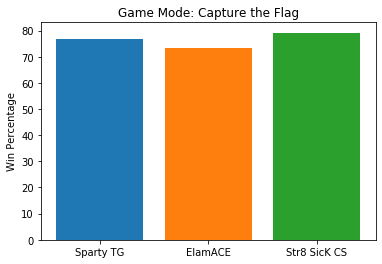

In [25]:
halo5.gametype_graph_bar('Win Percentage', 'Capture the Flag')

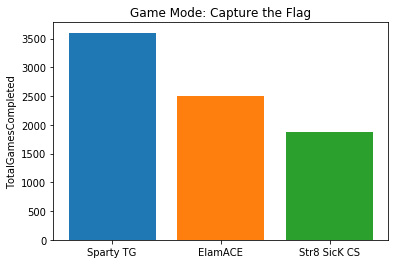

In [26]:
halo5.gametype_graph_bar('TotalGamesCompleted', 'Capture the Flag')

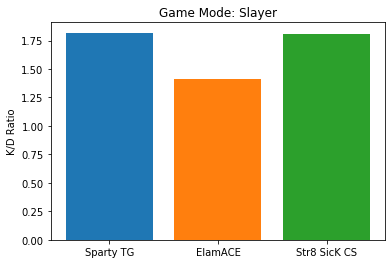

In [27]:
halo5.gametype_graph_bar('K/D Ratio', 'Slayer')

In [ ]:
halo5match = Api()
halo5match.retrieve_match_data()
player_data_match[player_gamertags[0]]